## Simple CNN deblender
In this notebook we create a simple convnet on an images of two-galaxy blends in orde to separate out the central galaxy. The input is $32 \times 32$ postage stamps of  differnt two galaxy blends in 2 filters (V and I). The galaxies were selected from one square degree catalog from catsim and drawn as seen by LSST. The distance between the galaxies and tehir orientatiions were selected randomly from a uniform distribution. 

This notebook is a simple excerise to demonstrate using CNN in galaxy image deblending. We train on 180 galaxy blends and test on 20 blends.

We use Tensor flow to create and optimize the net.

In [33]:
import tensorflow as tf
from astropy.io import fits

%matplotlib inline
from __future__ import division
import os
import sys
import tensorflow as tf
import skimage.io as io
import numpy as np
scripts = os.path.join(os.path.dirname(os.getcwd()), "scripts")
sys.path.insert(0, scripts)
import math
import matplotlib.pyplot as plt

# this contains script to load data and divide them into test and training set
from data_utils import get_data

('Train data input shape: ', (180, 32, 32, 2))
('Train data output shape: ', (180, 32, 32))
('Validation data input shape: ', (20, 32, 32, 2))
('Validation data output  shape: ', (20, 32, 32))


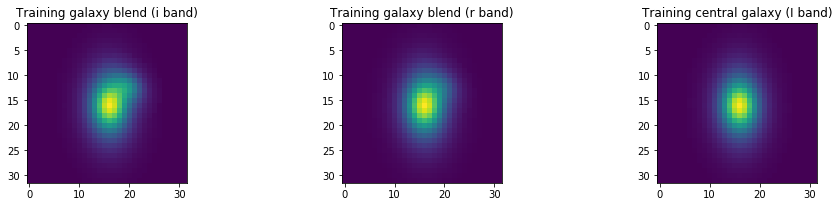

In [96]:
# Load data
X_train, Y_train, X_val, Y_val = get_data()
print('Train data input shape: ', X_train.shape)
print('Train data output shape: ', Y_train.shape)
print('Validation data input shape: ', X_val.shape)
print('Validation data output  shape: ', Y_val.shape)
plt.figure(figsize=[16,10])
plt.subplot(3,3,1)
plt.imshow(X_train[0,:,:,0])
plt.title('Training galaxy blend (i band)')
plt.subplot(3,3,2)
plt.imshow(X_train[0,:,:,1])
plt.title('Training galaxy blend (r band)')
plt.subplot(3,3,3)
plt.imshow(Y_train[0,:,:])
plt.title('Training central galaxy (I band)')

We define below a 2 layer convnet:
- Layer 1: convolution layer
    - 256, $5 \times 5 \times 2$ kernels as Wconv1
    - 256, bias parameters as bconv1
    - ReLU activation
- Layer2: fully connected layer
    - 49, $32 \times 32 $ weights, W1
    - $32 \times 32 $ bias, b1

    

In [97]:
# clear old variables
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 2])
y = tf.placeholder(tf.float32, [None, 32, 32])
def simple_model(X,y):
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 2, 256])
    bconv1 = tf.get_variable("bconv1", shape=[256])
    W1 = tf.get_variable("W1", shape=[32,32,1,49])
    b1 = tf.get_variable("b1", shape=[32,32])
    
    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[32,32, 49, -1])
    y_out = tf.matmul(W1,h1_flat) #+ b1
    y_out = tf.transpose(y_out)
    y_out= tf.reshape(y_out, [-1,32,32])
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.nn.l2_loss(y - y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(1e-3) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

In [98]:
def run_model(session, X_train, Y_train, X_test, Y_test,
              epochs=1, batch_size=64, print_every=100):
    """Runs the simple training data and returns the mean loss ebery epoch.
    Every epoch the net is also run for validation set and mean loss computed.
    During training, the optimization is performed for mean loss over a batch
    of size batch_size
    """
    # shuffle indicies
    np.random.seed(1)
    train_indicies = np.arange(X_train.shape[0])
    np.random.shuffle(train_indicies)
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    iter_cnt = 0
    train_loss, test_loss = [], []
    print ("Running network for {0} epochs with {1} batches each".format(epochs, X_train.shape[0] / batch_size))
    for e in range(epochs):
        # keep track of losses and accuracy
        # make sure we iterate over the dataset once
        losses = []
        for i in range(int(math.ceil(X_train.shape[0] / batch_size))):  ## fix 
            # generate indicies for the batch
            start_idx = (i * batch_size)%X_train.shape[0]  #fix
            idx = train_indicies[start_idx:start_idx + batch_size]
            # create a feed dictionary for this batch
            feed_dict = {X: X_train[idx,:, :, :],
                         y: Y_train[idx,:, :]}
            variables = [mean_loss, train_step]
            loss, _ = session.run(variables, feed_dict=feed_dict)
            losses.append(loss * batch_size)
            # print every now and then
            if (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1}" \
                      .format(iter_cnt, loss))
            iter_cnt += 1
        train_loss.append(np.sum(losses)/X_train.shape[0])
        # compute mean loss for validation set
        variables = [mean_loss]
        feed_dict = {X: X_test,
                     y: Y_test}
        loss = session.run(variables, feed_dict=feed_dict)
        test_loss.append(loss)
    pred = y_out.eval(session=sess, feed_dict=feed_dict)
    return train_loss, test_loss, pred

Running network for 200 epochs with 11.25 batches each
Iteration 0: with minibatch training loss = 0.110966868699
Iteration 100: with minibatch training loss = 0.00640497496352
Iteration 200: with minibatch training loss = 0.00491427071393
Iteration 300: with minibatch training loss = 0.00612002145499
Iteration 400: with minibatch training loss = 0.00651226239279
Iteration 500: with minibatch training loss = 0.00497185206041
Iteration 600: with minibatch training loss = 0.00614233966917
Iteration 700: with minibatch training loss = 0.00653975829482
Iteration 800: with minibatch training loss = 0.00497400341555
Iteration 900: with minibatch training loss = 0.00612737424672
Iteration 1000: with minibatch training loss = 0.00652129249647
Iteration 1100: with minibatch training loss = 0.00495088472962
Iteration 1200: with minibatch training loss = 0.0061004916206
Iteration 1300: with minibatch training loss = 0.00649922667071
Iteration 1400: with minibatch training loss = 0.00492499722168


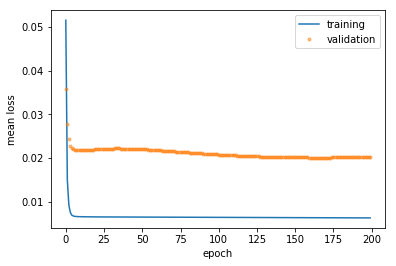

In [101]:
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        train_loss, val_loss, pred = run_model(sess,X_train, Y_train, X_val, Y_val,200,16,100)
plt.plot(train_loss, label='training')
plt.plot(val_loss, '.', label='validation', alpha=0.5)
plt.ylabel('mean loss')
plt.xlabel('epoch')
plt.legend()

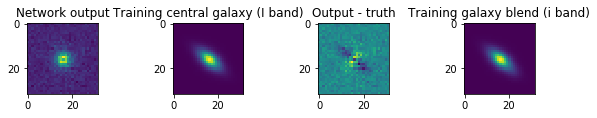

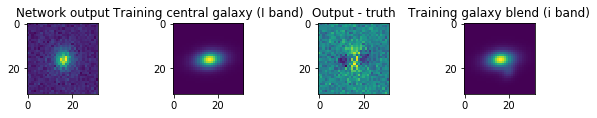

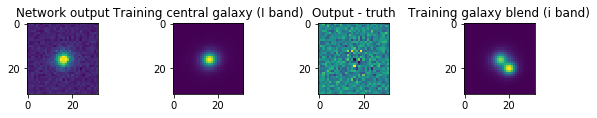

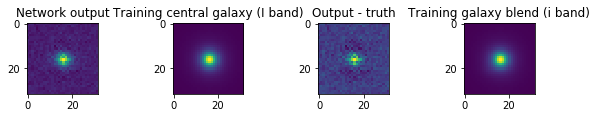

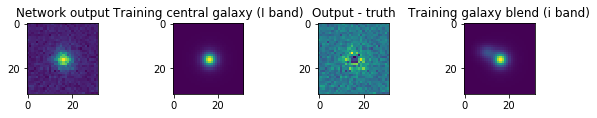

In [108]:
for num in range(5,10):
    plt.figure(figsize=[10,6])
    plt.subplot(4,4,1)
    plt.imshow(pred[num,:,:])
    plt.title('Network output')
    plt.subplot(4,4,2)
    plt.imshow(Y_val[num,:,:])
    plt.title('Training central galaxy (I band)')
    plt.subplot(4,4,3)
    plt.imshow(pred[num,:,:] - Y_val[num,:,:] )
    plt.title('Output - truth')
    plt.subplot(4,4,4)
    plt.imshow(X_val[num,:,:,0])
    plt.title('Training galaxy blend (i band)')


In [104]:
gr = tf.get_default_graph()

In [106]:
print [v.name for v in tf.global_variables()]

[u'Wconv1:0', u'bconv1:0', u'W1:0', u'b1:0', u'beta1_power:0', u'beta2_power:0', u'Wconv1/Adam:0', u'Wconv1/Adam_1:0', u'bconv1/Adam:0', u'bconv1/Adam_1:0', u'W1/Adam:0', u'W1/Adam_1:0']


In [107]:
conv1_kernel_val = gr.get_tensor_by_name('Wconv1:0').eval()

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [103]:
tf.get_default_graph?

In [16]:
np.random.seed?

Training
Iteration 0: with minibatch training loss = 0.25566226244
Epoch 1, Overall loss = 1.50111541814
Epoch 2, Overall loss = 1.4459766075
Epoch 3, Overall loss = 1.42285141597
Epoch 4, Overall loss = 1.40577332468
Epoch 5, Overall loss = 1.39176495373
Epoch 6, Overall loss = 1.3793766631
Epoch 7, Overall loss = 1.36867037416
Epoch 8, Overall loss = 1.35917917225
Epoch 9, Overall loss = 1.35102764186
Epoch 10, Overall loss = 1.34407461517
Epoch 11, Overall loss = 1.33815437307
Iteration 100: with minibatch training loss = 0.189641863108
Epoch 12, Overall loss = 1.33311088797
Epoch 13, Overall loss = 1.32882516997
Epoch 14, Overall loss = 1.32516147859
Epoch 15, Overall loss = 1.32216390305
Epoch 16, Overall loss = 1.3193724321
Epoch 17, Overall loss = 1.31731559998
Epoch 18, Overall loss = 1.31526877317
Epoch 19, Overall loss = 1.31363316708
Epoch 20, Overall loss = 1.31223911378
Epoch 21, Overall loss = 1.31106332607
Epoch 22, Overall loss = 1.31003862454
Iteration 200: with miniba

Epoch 185, Overall loss = 1.28692522976
Epoch 186, Overall loss = 1.28691016469
Epoch 187, Overall loss = 1.28690314293
Epoch 188, Overall loss = 1.28694320222
Iteration 1700: with minibatch training loss = 0.249051600695
Epoch 189, Overall loss = 1.28691137499
Epoch 190, Overall loss = 1.2866953214
Epoch 191, Overall loss = 1.28639987442
Epoch 192, Overall loss = 1.28622724281
Epoch 193, Overall loss = 1.28611505859
Epoch 194, Overall loss = 1.28584996363
Epoch 195, Overall loss = 1.28549365865
Epoch 196, Overall loss = 1.28527971605
Epoch 197, Overall loss = 1.28530742725
Epoch 198, Overall loss = 1.28556498057
Epoch 199, Overall loss = 1.28628552622
Epoch 200, Overall loss = 1.28729504512
Validation
Epoch 1, Overall loss = 0.196799784899
0
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


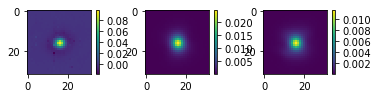

1
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


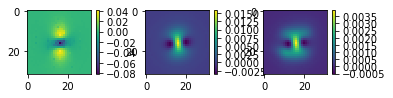

2
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


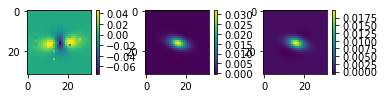

3
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


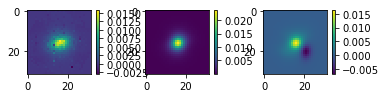

4
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


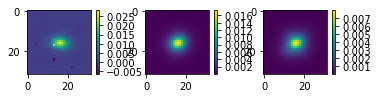

5
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


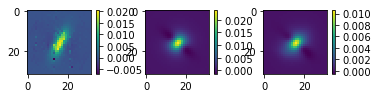

6
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


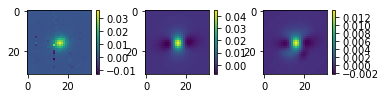

7
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


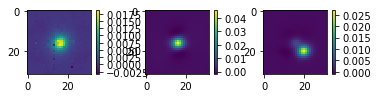

8
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


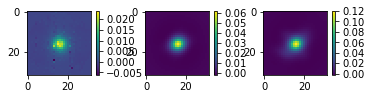

9
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


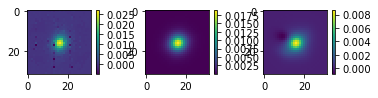

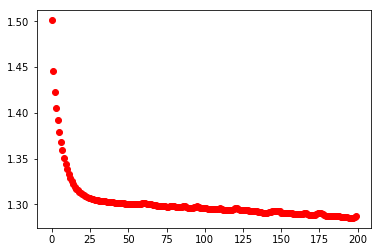

In [92]:
def run_model(session, predict, mean_loss, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    all_loss=[]
    # have tensorflow compute accuracy
    pred_loss = tf.reduce_mean((tf.nn.l2_loss(y - predict)))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, pred_loss,]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:, :, :],
                         y: yd[idx, :, :],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, im = session.run(variables,feed_dict=feed_dict)
            pred = y_out.eval(session=session, feed_dict=feed_dict)
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1}"\
                      .format(iter_cnt,loss))
            iter_cnt += 1
        total_loss = np.sum(losses)/Xd.shape[0]
        all_loss.append(total_loss)
        print("Epoch {1}, Overall loss = {0}"\
              .format(total_loss, e+1))
        if plot_losses and (e % print_every) == 0:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
        if training_now is False:
            for num in range(10):
                print  num
                plt.subplot(3,3,1)
                print pred.shape, yd.shape
                plt.imshow(pred[num])
                plt.colorbar()
                plt.subplot(3,3,2)
                plt.imshow(yd[num])
                plt.colorbar()
                plt.subplot(3,3,3)
                print Xd.shape
                plt.imshow(Xd[num, :, :,0])
                plt.colorbar()
                plt.show()
    return all_loss

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        train_loss = run_model(sess,y_out,mean_loss,X_train,Y_train,200,20,100,train_step,False)
        print('Validation')
        test_loss = run_model(sess,y_out,mean_loss,X_val,Y_val,1,20, 100)
        plt.plot(train_loss, 'ro')
        #plt.plot(test_loss, 'bo')

Training
Iteration 0: with minibatch training loss = 1.36334671872e+11
Epoch 1, Overall loss = 1.23907994055e+11
Epoch 2, Overall loss = 1.23828355982e+11
Epoch 3, Overall loss = 1.2370321226e+11
Epoch 4, Overall loss = 1.23484484494e+11
Epoch 5, Overall loss = 1.23160343893e+11
Epoch 6, Overall loss = 1.227497183e+11
Epoch 7, Overall loss = 1.22258834318e+11
Epoch 8, Overall loss = 1.21691773156e+11
Epoch 9, Overall loss = 1.21063237177e+11
Epoch 10, Overall loss = 1.20436971748e+11
Epoch 11, Overall loss = 1.19833597952e+11
Iteration 100: with minibatch training loss = 75254333440.0
Epoch 12, Overall loss = 1.192706849e+11
Epoch 13, Overall loss = 1.18654627385e+11
Epoch 14, Overall loss = 1.17991978098e+11
Epoch 15, Overall loss = 1.17348862635e+11
Epoch 16, Overall loss = 1.16708129223e+11
Epoch 17, Overall loss = 1.16117065956e+11
Epoch 18, Overall loss = 1.15576210091e+11
Epoch 19, Overall loss = 1.15105229938e+11
Epoch 20, Overall loss = 1.14735349532e+11
Epoch 21, Overall loss 

Epoch 179, Overall loss = 94299541959.1
Epoch 180, Overall loss = 94460257848.9
Epoch 181, Overall loss = 94576416768.0
Epoch 182, Overall loss = 94617612288.0
Epoch 183, Overall loss = 94692604359.1
Epoch 184, Overall loss = 94626564778.7
Epoch 185, Overall loss = 94223242353.8
Epoch 186, Overall loss = 93766261191.1
Epoch 187, Overall loss = 93526352554.7
Epoch 188, Overall loss = 93445757610.7
Iteration 1700: with minibatch training loss = 30630932480.0
Epoch 189, Overall loss = 93402144768.0
Epoch 190, Overall loss = 93364439267.6
Epoch 191, Overall loss = 93330108643.6
Epoch 192, Overall loss = 93309021752.9
Epoch 193, Overall loss = 93294086599.1
Epoch 194, Overall loss = 93308089002.7
Epoch 195, Overall loss = 93339697834.7
Epoch 196, Overall loss = 93398187121.8
Epoch 197, Overall loss = 93420507591.1
Epoch 198, Overall loss = 93513264241.8
Epoch 199, Overall loss = 93789000590.2
Epoch 200, Overall loss = 94265779996.4
Validation
Epoch 1, Overall loss = 1.46149081088e+11
0
(20,

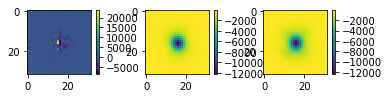

1
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


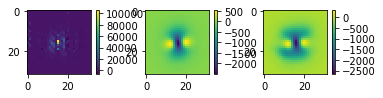

2
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


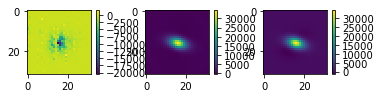

3
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


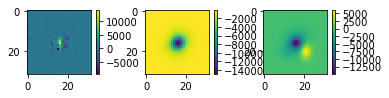

4
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


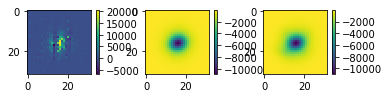

5
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


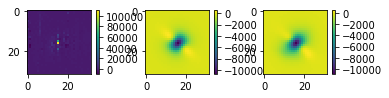

6
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


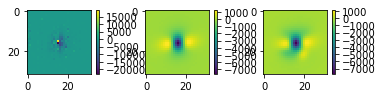

7
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


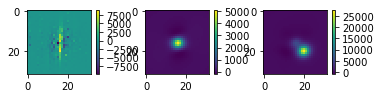

8
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


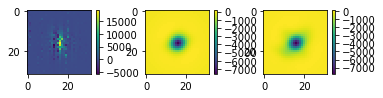

9
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


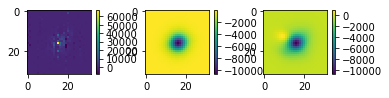

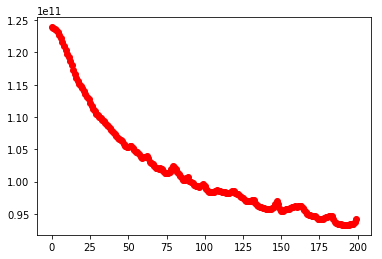

In [14]:
def run_model(session, predict, mean_loss, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    all_loss=[]
    # have tensorflow compute accuracy
    pred_loss = tf.reduce_mean((tf.nn.l2_loss(y - predict)))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, pred_loss,]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:, :, :],
                         y: yd[idx, :, :],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, im = session.run(variables,feed_dict=feed_dict)
            pred = y_out.eval(session=session, feed_dict=feed_dict)
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1}"\
                      .format(iter_cnt,loss))
            iter_cnt += 1
        total_loss = np.sum(losses)/Xd.shape[0]
        all_loss.append(total_loss)
        print("Epoch {1}, Overall loss = {0}"\
              .format(total_loss, e+1))
        if plot_losses and (e % print_every) == 0:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
        if training_now is False:
            for num in range(10):
                print  num
                plt.subplot(3,3,1)
                print pred.shape, yd.shape
                plt.imshow(pred[num])
                plt.colorbar()
                plt.subplot(3,3,2)
                plt.imshow(yd[num])
                plt.colorbar()
                plt.subplot(3,3,3)
                print Xd.shape
                plt.imshow(Xd[num, :, :,0])
                plt.colorbar()
                plt.show()
    return all_loss

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        train_loss = run_model(sess,y_out,mean_loss,X_train,Y_train,200,20,100,train_step,False)
        print('Validation')
        test_loss = run_model(sess,y_out,mean_loss,X_val,Y_val,1,20, 100)
        plt.plot(train_loss, 'ro')
        #plt.plot(test_loss, 'bo')

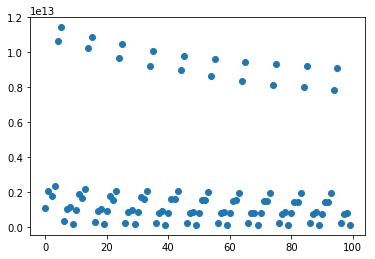

In [40]:
plt.plot(np.array(train_loss)[0:100], 'o')

In [21]:
test_loss

[3737913262080.0]

In [37]:
np.array(train_loss).shape

(2000,)

Training
Iteration 0: with minibatch training loss = 1.9885391872e+11
Epoch 1, Overall loss = 1.81257036686e+11


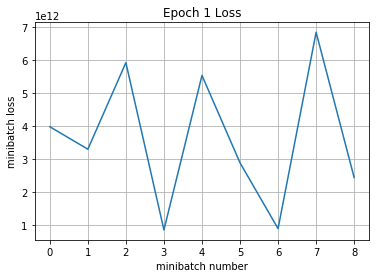

Iteration 10: with minibatch training loss = 1.6306536448e+11
Epoch 2, Overall loss = 1.79829035008e+11
Iteration 20: with minibatch training loss = 2.9328867328e+11
Epoch 3, Overall loss = 1.7750122314e+11
Iteration 30: with minibatch training loss = 39899348992.0
Epoch 4, Overall loss = 1.74759916885e+11
Iteration 40: with minibatch training loss = 2.60850941952e+11
Epoch 5, Overall loss = 1.7176258469e+11
Iteration 50: with minibatch training loss = 1.3173563392e+11
Epoch 6, Overall loss = 1.68781589163e+11
Iteration 60: with minibatch training loss = 35448909824.0
Epoch 7, Overall loss = 1.65859828167e+11
Iteration 70: with minibatch training loss = 3.22304802816e+11
Epoch 8, Overall loss = 1.63025820103e+11
Iteration 80: with minibatch training loss = 1.01566660608e+11
Epoch 9, Overall loss = 1.60355478414e+11
Epoch 10, Overall loss = 1.57907744996e+11
Iteration 90: with minibatch training loss = 1.71479105536e+11
Epoch 11, Overall loss = 1.55695732964e+11


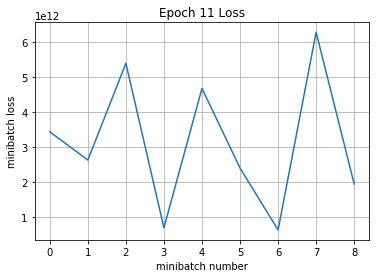

Iteration 100: with minibatch training loss = 1.28484810752e+11
Epoch 12, Overall loss = 1.53684035356e+11
Iteration 110: with minibatch training loss = 2.64027029504e+11
Epoch 13, Overall loss = 1.51838184562e+11
Iteration 120: with minibatch training loss = 34009284608.0
Epoch 14, Overall loss = 1.50158067484e+11
Iteration 130: with minibatch training loss = 2.20478455808e+11
Epoch 15, Overall loss = 1.48646585003e+11
Iteration 140: with minibatch training loss = 1.13240203264e+11
Epoch 16, Overall loss = 1.47300067556e+11
Iteration 150: with minibatch training loss = 30144419840.0
Epoch 17, Overall loss = 1.46014986695e+11
Iteration 160: with minibatch training loss = 2.98740482048e+11
Epoch 18, Overall loss = 1.44809415339e+11
Iteration 170: with minibatch training loss = 86993534976.0
Epoch 19, Overall loss = 1.43724812516e+11
Epoch 20, Overall loss = 1.42739417771e+11
Iteration 180: with minibatch training loss = 1.5234048e+11
Epoch 21, Overall loss = 1.41812111132e+11


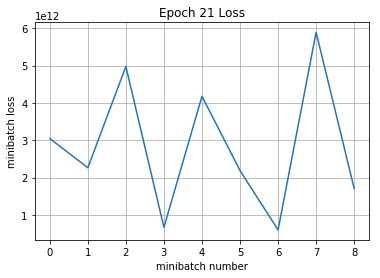

Iteration 190: with minibatch training loss = 1.12189243392e+11
Epoch 22, Overall loss = 1.40881796892e+11
Iteration 200: with minibatch training loss = 2.45844180992e+11
Epoch 23, Overall loss = 1.3997103013e+11
Iteration 210: with minibatch training loss = 32961060864.0
Epoch 24, Overall loss = 1.39092596053e+11
Iteration 220: with minibatch training loss = 2.03965612032e+11
Epoch 25, Overall loss = 1.38385292629e+11
Iteration 230: with minibatch training loss = 1.06681393152e+11
Epoch 26, Overall loss = 1.37603254955e+11
Iteration 240: with minibatch training loss = 29442934784.0
Epoch 27, Overall loss = 1.36684884196e+11
Iteration 250: with minibatch training loss = 2.8542844928e+11
Epoch 28, Overall loss = 1.35881726635e+11
Iteration 260: with minibatch training loss = 80540852224.0
Epoch 29, Overall loss = 1.35179476309e+11
Epoch 30, Overall loss = 1.34498158592e+11
Iteration 270: with minibatch training loss = 1.41314392064e+11
Epoch 31, Overall loss = 1.33818986724e+11


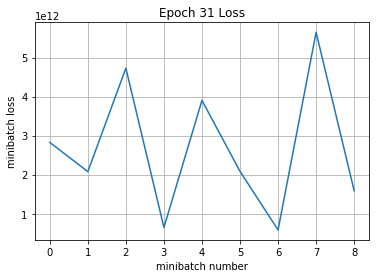

Iteration 280: with minibatch training loss = 1.030203392e+11
Epoch 32, Overall loss = 1.33164795449e+11
Iteration 290: with minibatch training loss = 2.33238986752e+11
Epoch 33, Overall loss = 1.32603674624e+11
Iteration 300: with minibatch training loss = 32220985344.0
Epoch 34, Overall loss = 1.32123955883e+11
Iteration 310: with minibatch training loss = 1.89943513088e+11
Epoch 35, Overall loss = 1.31392168164e+11
Iteration 320: with minibatch training loss = 1.02269124608e+11
Epoch 36, Overall loss = 1.30646958308e+11
Iteration 330: with minibatch training loss = 29199370240.0
Epoch 37, Overall loss = 1.30081784036e+11
Iteration 340: with minibatch training loss = 2.77588279296e+11
Epoch 38, Overall loss = 1.29522664789e+11
Iteration 350: with minibatch training loss = 75576377344.0
Epoch 39, Overall loss = 1.2892069888e+11
Epoch 40, Overall loss = 1.28292931356e+11
Iteration 360: with minibatch training loss = 1.33847400448e+11
Epoch 41, Overall loss = 1.27737152853e+11


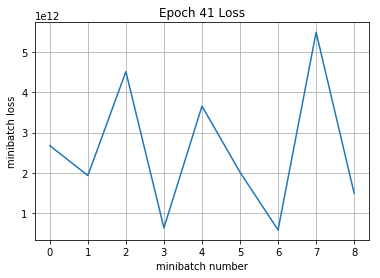

Iteration 370: with minibatch training loss = 95892955136.0
Epoch 42, Overall loss = 1.27207849301e+11
Iteration 380: with minibatch training loss = 2.23827001344e+11
Epoch 43, Overall loss = 1.26726761358e+11
Iteration 390: with minibatch training loss = 31896051712.0
Epoch 44, Overall loss = 1.26331100956e+11
Iteration 400: with minibatch training loss = 1.78544214016e+11
Epoch 45, Overall loss = 1.25874999751e+11
Iteration 410: with minibatch training loss = 99611795456.0
Epoch 46, Overall loss = 1.2544146523e+11
Iteration 420: with minibatch training loss = 29830062080.0
Epoch 47, Overall loss = 1.24974715108e+11
Iteration 430: with minibatch training loss = 2.70525120512e+11
Epoch 48, Overall loss = 1.24616122823e+11
Iteration 440: with minibatch training loss = 72032796672.0
Epoch 49, Overall loss = 1.24239398457e+11
Epoch 50, Overall loss = 1.23784909255e+11
Iteration 450: with minibatch training loss = 1.29497776128e+11
Epoch 51, Overall loss = 1.23301250389e+11


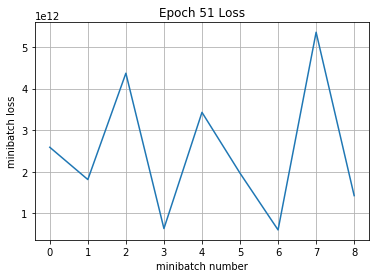

Iteration 460: with minibatch training loss = 90132946944.0
Epoch 52, Overall loss = 1.22952747236e+11
Iteration 470: with minibatch training loss = 2.172817408e+11
Epoch 53, Overall loss = 1.22570567225e+11
Iteration 480: with minibatch training loss = 31956457472.0
Epoch 54, Overall loss = 1.221240543e+11
Iteration 490: with minibatch training loss = 1.67544389632e+11
Epoch 55, Overall loss = 1.21803329308e+11
Iteration 500: with minibatch training loss = 97726201856.0
Epoch 56, Overall loss = 1.21446003826e+11
Iteration 510: with minibatch training loss = 30861242368.0
Epoch 57, Overall loss = 1.20940924018e+11
Iteration 520: with minibatch training loss = 2.64123973632e+11
Epoch 58, Overall loss = 1.20505570418e+11
Iteration 530: with minibatch training loss = 69134548992.0
Epoch 59, Overall loss = 1.20117427769e+11
Epoch 60, Overall loss = 1.19795113756e+11
Iteration 540: with minibatch training loss = 1.24592422912e+11
Epoch 61, Overall loss = 1.1943231306e+11


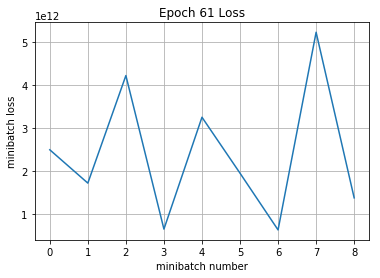

Iteration 550: with minibatch training loss = 85289287680.0
Epoch 62, Overall loss = 1.191778081e+11
Iteration 560: with minibatch training loss = 2.09723490304e+11
Epoch 63, Overall loss = 1.18793148644e+11
Iteration 570: with minibatch training loss = 32487858176.0
Epoch 64, Overall loss = 1.18671282859e+11
Iteration 580: with minibatch training loss = 1.59870386176e+11
Epoch 65, Overall loss = 1.18450171221e+11
Iteration 590: with minibatch training loss = 96936624128.0
Epoch 66, Overall loss = 1.18418633614e+11
Iteration 600: with minibatch training loss = 31861231616.0
Epoch 67, Overall loss = 1.18138291541e+11
Iteration 610: with minibatch training loss = 2.60885446656e+11
Epoch 68, Overall loss = 1.1814795082e+11
Iteration 620: with minibatch training loss = 67084800000.0
Epoch 69, Overall loss = 1.17829474532e+11
Epoch 70, Overall loss = 1.17399525604e+11
Iteration 630: with minibatch training loss = 1.22052108288e+11
Epoch 71, Overall loss = 1.16926119481e+11


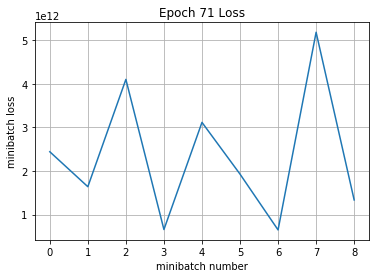

Iteration 640: with minibatch training loss = 81424343040.0
Epoch 72, Overall loss = 1.1675944118e+11
Iteration 650: with minibatch training loss = 2.04152471552e+11
Epoch 73, Overall loss = 1.16569315783e+11
Iteration 660: with minibatch training loss = 32986611712.0
Epoch 74, Overall loss = 1.16386669454e+11
Iteration 670: with minibatch training loss = 1.5344197632e+11
Epoch 75, Overall loss = 1.16074393372e+11
Iteration 680: with minibatch training loss = 95998779392.0
Epoch 76, Overall loss = 1.15705802297e+11
Iteration 690: with minibatch training loss = 32881926144.0
Epoch 77, Overall loss = 1.15412148907e+11
Iteration 700: with minibatch training loss = 2.53972824064e+11
Epoch 78, Overall loss = 1.1524360101e+11
Iteration 710: with minibatch training loss = 65481093120.0
Epoch 79, Overall loss = 1.14957908651e+11
Epoch 80, Overall loss = 1.14646082901e+11
Iteration 720: with minibatch training loss = 1.19135543296e+11
Epoch 81, Overall loss = 1.14316747207e+11


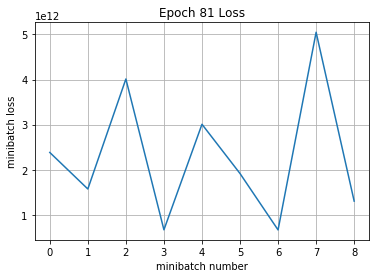

Iteration 730: with minibatch training loss = 78278893568.0
Epoch 82, Overall loss = 1.14084908828e+11
Iteration 740: with minibatch training loss = 1.99284670464e+11
Epoch 83, Overall loss = 1.13950237582e+11
Iteration 750: with minibatch training loss = 33530533888.0
Epoch 84, Overall loss = 1.13941094172e+11
Iteration 760: with minibatch training loss = 1.48314652672e+11
Epoch 85, Overall loss = 1.13775628971e+11
Iteration 770: with minibatch training loss = 95645917184.0
Epoch 86, Overall loss = 1.13450501461e+11
Iteration 780: with minibatch training loss = 33794260992.0
Epoch 87, Overall loss = 1.13126023168e+11
Iteration 790: with minibatch training loss = 2.50139672576e+11
Epoch 88, Overall loss = 1.12950914617e+11
Iteration 800: with minibatch training loss = 64272310272.0
Epoch 89, Overall loss = 1.12770617572e+11
Epoch 90, Overall loss = 1.1269232549e+11
Iteration 810: with minibatch training loss = 1.17489057792e+11
Epoch 91, Overall loss = 1.12561300366e+11


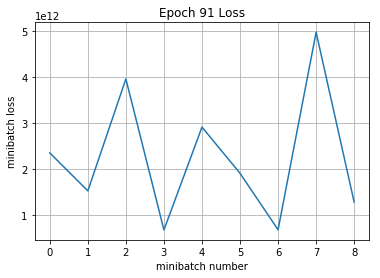

Iteration 820: with minibatch training loss = 75916615680.0
Epoch 92, Overall loss = 1.12486429355e+11
Iteration 830: with minibatch training loss = 1.96371136512e+11
Epoch 93, Overall loss = 1.12232406812e+11
Iteration 840: with minibatch training loss = 34033731584.0
Epoch 94, Overall loss = 1.12233535716e+11
Iteration 850: with minibatch training loss = 1.44048996352e+11
Epoch 95, Overall loss = 1.12408112469e+11
Iteration 860: with minibatch training loss = 96206528512.0
Epoch 96, Overall loss = 1.12746979556e+11
Iteration 870: with minibatch training loss = 34519101440.0
Epoch 97, Overall loss = 1.12699202901e+11
Iteration 880: with minibatch training loss = 2.55602753536e+11
Epoch 98, Overall loss = 1.12618834603e+11
Iteration 890: with minibatch training loss = 63040282624.0
Epoch 99, Overall loss = 1.12123072057e+11
Epoch 100, Overall loss = 1.11631773241e+11
Iteration 900: with minibatch training loss = 1.17595766784e+11
Epoch 101, Overall loss = 1.11169914197e+11


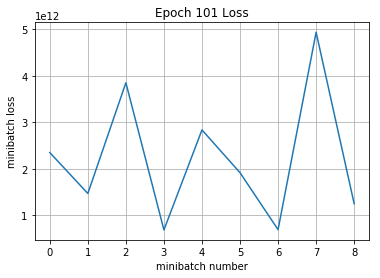

Iteration 910: with minibatch training loss = 73124364288.0
Epoch 102, Overall loss = 1.11022911943e+11
Iteration 920: with minibatch training loss = 1.91471845376e+11
Epoch 103, Overall loss = 1.10661037625e+11
Iteration 930: with minibatch training loss = 34555105280.0
Epoch 104, Overall loss = 1.10594948665e+11
Iteration 940: with minibatch training loss = 1.42032945152e+11
Epoch 105, Overall loss = 1.10403608121e+11
Iteration 950: with minibatch training loss = 95358050304.0
Epoch 106, Overall loss = 1.10486428786e+11
Iteration 960: with minibatch training loss = 35123724288.0
Epoch 107, Overall loss = 1.10271934464e+11
Iteration 970: with minibatch training loss = 2.44402896896e+11
Epoch 108, Overall loss = 1.10415137451e+11
Iteration 980: with minibatch training loss = 61928636416.0
Epoch 109, Overall loss = 1.1020722176e+11
Epoch 110, Overall loss = 1.10066482745e+11
Iteration 990: with minibatch training loss = 1.15398524928e+11
Epoch 111, Overall loss = 1.09522076103e+11


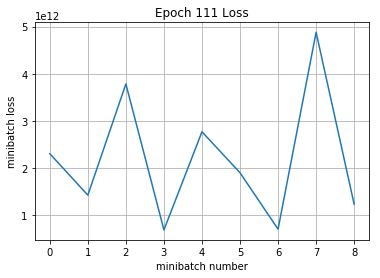

Iteration 1000: with minibatch training loss = 70925549568.0
Epoch 112, Overall loss = 1.09330672299e+11
Iteration 1010: with minibatch training loss = 1.88451192832e+11
Epoch 113, Overall loss = 1.08963726222e+11
Iteration 1020: with minibatch training loss = 34784378880.0
Epoch 114, Overall loss = 1.08866666951e+11
Iteration 1030: with minibatch training loss = 1.37001689088e+11
Epoch 115, Overall loss = 1.08597500587e+11
Iteration 1040: with minibatch training loss = 94896308224.0
Epoch 116, Overall loss = 1.08547377835e+11
Iteration 1050: with minibatch training loss = 35599360000.0
Epoch 117, Overall loss = 1.08342561451e+11
Iteration 1060: with minibatch training loss = 2.40568696832e+11
Epoch 118, Overall loss = 1.08301799424e+11
Iteration 1070: with minibatch training loss = 60967981056.0
Epoch 119, Overall loss = 1.08070137401e+11
Epoch 120, Overall loss = 1.08000799403e+11
Iteration 1080: with minibatch training loss = 1.13301929984e+11
Epoch 121, Overall loss = 1.07843088839

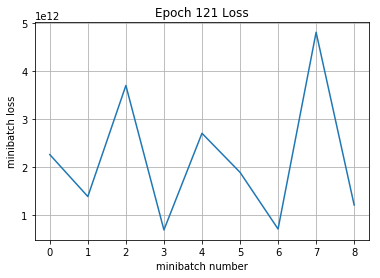

Iteration 1090: with minibatch training loss = 69308473344.0
Epoch 122, Overall loss = 1.07866289493e+11
Iteration 1100: with minibatch training loss = 1.84303058944e+11
Epoch 123, Overall loss = 1.07601932288e+11
Iteration 1110: with minibatch training loss = 35058536448.0
Epoch 124, Overall loss = 1.07463623111e+11
Iteration 1120: with minibatch training loss = 1.34093832192e+11
Epoch 125, Overall loss = 1.07244411108e+11
Iteration 1130: with minibatch training loss = 95091556352.0
Epoch 126, Overall loss = 1.07370372665e+11
Iteration 1140: with minibatch training loss = 36159021056.0
Epoch 127, Overall loss = 1.07368462564e+11
Iteration 1150: with minibatch training loss = 2.4310325248e+11
Epoch 128, Overall loss = 1.07491758535e+11
Iteration 1160: with minibatch training loss = 60122046464.0
Epoch 129, Overall loss = 1.07229871218e+11
Epoch 130, Overall loss = 1.0705479589e+11
Iteration 1170: with minibatch training loss = 1.136494592e+11
Epoch 131, Overall loss = 1.06770629518e+11

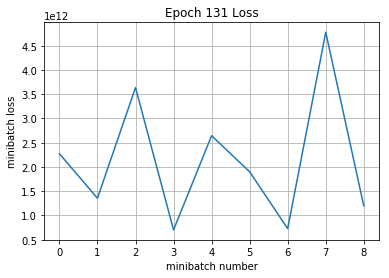

Iteration 1180: with minibatch training loss = 67476512768.0
Epoch 132, Overall loss = 1.06842828345e+11
Iteration 1190: with minibatch training loss = 1.81304721408e+11
Epoch 133, Overall loss = 1.06741342663e+11
Iteration 1200: with minibatch training loss = 35416887296.0
Epoch 134, Overall loss = 1.06898682766e+11
Iteration 1210: with minibatch training loss = 1.31280896e+11
Epoch 135, Overall loss = 1.06923686571e+11
Iteration 1220: with minibatch training loss = 95392120832.0
Epoch 136, Overall loss = 1.07671605248e+11
Iteration 1230: with minibatch training loss = 36776960000.0
Epoch 137, Overall loss = 1.08000453063e+11
Iteration 1240: with minibatch training loss = 2.51477426176e+11
Epoch 138, Overall loss = 1.08059242951e+11
Iteration 1250: with minibatch training loss = 59528331264.0
Epoch 139, Overall loss = 1.07265296156e+11
Epoch 140, Overall loss = 1.0648702794e+11
Iteration 1260: with minibatch training loss = 1.11910150144e+11
Epoch 141, Overall loss = 1.05687632555e+11

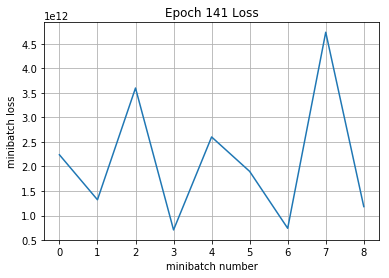

Iteration 1270: with minibatch training loss = 65630384128.0
Epoch 142, Overall loss = 1.05564665628e+11
Iteration 1280: with minibatch training loss = 1.78388795392e+11
Epoch 143, Overall loss = 1.05351308629e+11
Iteration 1290: with minibatch training loss = 35585449984.0
Epoch 144, Overall loss = 1.05391605988e+11
Iteration 1300: with minibatch training loss = 1.295214592e+11
Epoch 145, Overall loss = 1.05240509554e+11
Iteration 1310: with minibatch training loss = 95234850816.0
Epoch 146, Overall loss = 1.05310400967e+11
Iteration 1320: with minibatch training loss = 37145530368.0
Epoch 147, Overall loss = 1.05149453653e+11
Iteration 1330: with minibatch training loss = 2.33839755264e+11
Epoch 148, Overall loss = 1.05139336533e+11
Iteration 1340: with minibatch training loss = 58676408320.0
Epoch 149, Overall loss = 1.04894311083e+11
Epoch 150, Overall loss = 1.04775731428e+11
Iteration 1350: with minibatch training loss = 1.11775055872e+11
Epoch 151, Overall loss = 1.04477396537e+

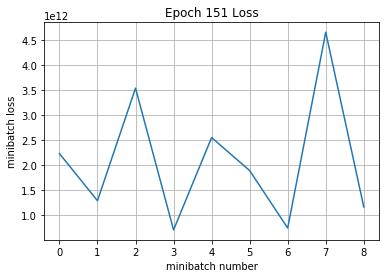

Iteration 1360: with minibatch training loss = 64379273216.0
Epoch 152, Overall loss = 1.04429592121e+11
Iteration 1370: with minibatch training loss = 1.76363962368e+11
Epoch 153, Overall loss = 1.04216224199e+11
Iteration 1380: with minibatch training loss = 35667705856.0
Epoch 154, Overall loss = 1.04184111104e+11
Iteration 1390: with minibatch training loss = 1.26648172544e+11
Epoch 155, Overall loss = 1.04069482724e+11
Iteration 1400: with minibatch training loss = 94994186240.0
Epoch 156, Overall loss = 1.04075794204e+11
Iteration 1410: with minibatch training loss = 37549023232.0
Epoch 157, Overall loss = 1.03866949632e+11
Iteration 1420: with minibatch training loss = 2.31608614912e+11
Epoch 158, Overall loss = 1.038626816e+11
Iteration 1430: with minibatch training loss = 58051448832.0
Epoch 159, Overall loss = 1.03711528277e+11
Epoch 160, Overall loss = 1.0373975882e+11
Iteration 1440: with minibatch training loss = 1.10104035328e+11
Epoch 161, Overall loss = 1.0347247707e+11

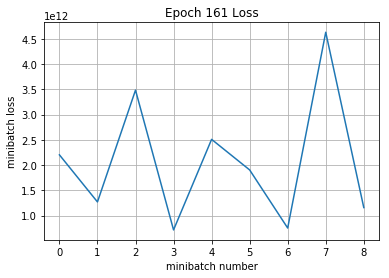

Iteration 1450: with minibatch training loss = 63171469312.0
Epoch 162, Overall loss = 1.03515369472e+11
Iteration 1460: with minibatch training loss = 1.74766292992e+11
Epoch 163, Overall loss = 1.03437213241e+11
Iteration 1470: with minibatch training loss = 36420689920.0
Epoch 164, Overall loss = 1.03686121244e+11
Iteration 1480: with minibatch training loss = 1.24955344896e+11
Epoch 165, Overall loss = 1.03452205056e+11
Iteration 1490: with minibatch training loss = 97238474752.0
Epoch 166, Overall loss = 1.03507159723e+11
Iteration 1500: with minibatch training loss = 38102970368.0
Epoch 167, Overall loss = 1.03090414478e+11
Iteration 1510: with minibatch training loss = 2.29703417856e+11
Epoch 168, Overall loss = 1.03119371833e+11
Iteration 1520: with minibatch training loss = 57521983488.0
Epoch 169, Overall loss = 1.02730792505e+11
Epoch 170, Overall loss = 1.02823600128e+11
Iteration 1530: with minibatch training loss = 1.09513048064e+11
Epoch 171, Overall loss = 1.02575052572

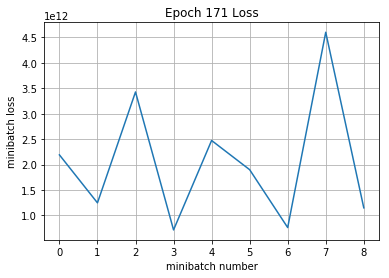

Iteration 1540: with minibatch training loss = 62129676288.0
Epoch 172, Overall loss = 1.02693454734e+11
Iteration 1550: with minibatch training loss = 1.7246978048e+11
Epoch 173, Overall loss = 1.02602177195e+11
Iteration 1560: with minibatch training loss = 36100136960.0
Epoch 174, Overall loss = 1.02965637575e+11
Iteration 1570: with minibatch training loss = 1.2313296896e+11
Epoch 175, Overall loss = 1.02872019854e+11
Iteration 1580: with minibatch training loss = 95152922624.0
Epoch 176, Overall loss = 1.02940290617e+11
Iteration 1590: with minibatch training loss = 38417801216.0
Epoch 177, Overall loss = 1.02490651762e+11
Iteration 1600: with minibatch training loss = 2.29859426304e+11
Epoch 178, Overall loss = 1.02380429312e+11
Iteration 1610: with minibatch training loss = 56858292224.0
Epoch 179, Overall loss = 1.02188861668e+11
Epoch 180, Overall loss = 1.02314789092e+11
Iteration 1620: with minibatch training loss = 1.1293945856e+11
Epoch 181, Overall loss = 1.02231808683e+1

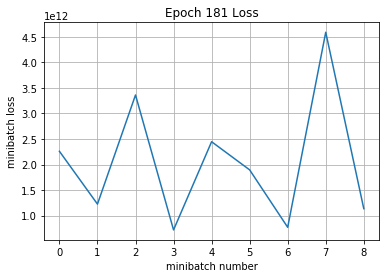

Iteration 1630: with minibatch training loss = 60920012800.0
Epoch 182, Overall loss = 1.02054615268e+11
Iteration 1640: with minibatch training loss = 1.67721582592e+11
Epoch 183, Overall loss = 1.01636160626e+11
Iteration 1650: with minibatch training loss = 36103335936.0
Epoch 184, Overall loss = 1.01614615211e+11
Iteration 1660: with minibatch training loss = 1.2141617152e+11
Epoch 185, Overall loss = 1.01887885312e+11
Iteration 1670: with minibatch training loss = 95075844096.0
Epoch 186, Overall loss = 1.02796015388e+11
Iteration 1680: with minibatch training loss = 38825070592.0
Epoch 187, Overall loss = 1.03438223132e+11
Iteration 1690: with minibatch training loss = 2.39315124224e+11
Epoch 188, Overall loss = 1.0318794661e+11
Iteration 1700: with minibatch training loss = 56406433792.0
Epoch 189, Overall loss = 1.02059844494e+11
Epoch 190, Overall loss = 1.01468178204e+11
Iteration 1710: with minibatch training loss = 1.11594676224e+11
Epoch 191, Overall loss = 1.0104612682e+1

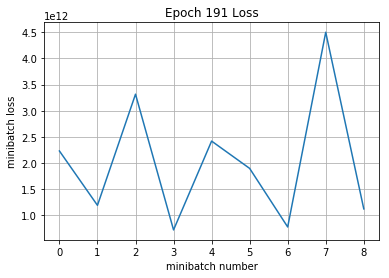

Iteration 1720: with minibatch training loss = 59220811776.0
Epoch 192, Overall loss = 1.00751742748e+11
Iteration 1730: with minibatch training loss = 1.65069357056e+11
Epoch 193, Overall loss = 1.0044788827e+11
Iteration 1740: with minibatch training loss = 36184068096.0
Epoch 194, Overall loss = 1.00333053269e+11
Iteration 1750: with minibatch training loss = 1.19543226368e+11
Epoch 195, Overall loss = 1.00224725447e+11
Iteration 1760: with minibatch training loss = 94766964736.0
Epoch 196, Overall loss = 1.00180454514e+11
Iteration 1770: with minibatch training loss = 39216095232.0
Epoch 197, Overall loss = 1.00082277945e+11
Iteration 1780: with minibatch training loss = 2.23375147008e+11
Epoch 198, Overall loss = 1.00036739982e+11
Iteration 1790: with minibatch training loss = 56038064128.0
Epoch 199, Overall loss = 99871057237.3
Epoch 200, Overall loss = 99794141184.0
Validation
Epoch 1, Overall loss = 1.44866639872e+11
0
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


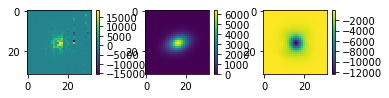

1
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


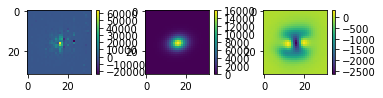

2
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


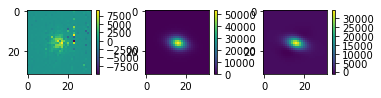

3
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


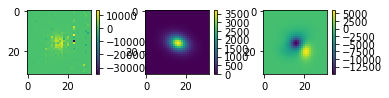

4
(20, 32, 32) (20, 32, 32)
(20, 32, 32, 2)


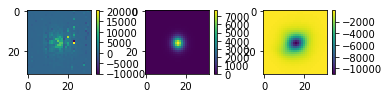

In [94]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 2])
y = tf.placeholder(tf.float32, [None, 32, 32])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 2, 256])
    bconv1 = tf.get_variable("bconv1", shape=[256])
    W1 = tf.get_variable("W1", shape=[32,32,1,49])
    b1 = tf.get_variable("b1", shape=[32,32])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[32,32, 49, -1])
    y_out = tf.matmul(W1,h1_flat) #+ b1
    y_out = tf.transpose(y_out)
    y_out= tf.reshape(y_out, [-1,32,32])
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.nn.l2_loss(y - y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(1e-3) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)


def run_model(session, predict, mean_loss, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    pred_loss = tf.reduce_mean((tf.nn.l2_loss(y - predict)))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, pred_loss,]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:, :, :],
                         y: yd[idx, :, :],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, im = session.run(variables,feed_dict=feed_dict)
            pred = y_out.eval(session=session, feed_dict=feed_dict)
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1}"\
                      .format(iter_cnt,loss))
            iter_cnt += 1
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0}"\
              .format(total_loss, e+1))
        if plot_losses and (e % print_every) == 0:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
        if training_now is False:
            for num in range(5):
                print  num
                plt.subplot(3,3,1)
                print pred.shape, yd.shape
                plt.imshow(pred[num])
                plt.colorbar()
                plt.subplot(3,3,2)
                plt.imshow(yd[num])
                plt.colorbar()
                plt.subplot(3,3,3)
                print Xd.shape
                plt.imshow(Xd[num, :, :,0])
                plt.colorbar()
                plt.show()
    return total_loss

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,Y_train,200,20,10,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,Y_val,1,20)

In [15]:
tf.layers.conv2d?

In [90]:
im=np.mean(X_train, axis=0)
im.shape

(32, 32, 2)

In [88]:
im

-2.9684896516199743e-14

In [ ]:
tf.variable_scope?

tf.nn.conv2d_transpose?

tf.reset_default_graph?